# Name: Oliver JACK (olijacklu@gmail.com)

# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
from scipy.io import loadmat
import os
from helper import build_similarity_graph, build_laplacian, build_laplacian_regularized, plot_classification, mask_labels

In [2]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = 0.0

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = 10

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'sym'

# Coefficients for C matrix for soft HFS
params['c_l'] = 1.0
params['c_u'] = 0.0

In [3]:
def compute_hfs(L, Y, soft=False, c_l=1.0, c_u=0.0):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1

    l_idx = np.where(Y != 0)[0]
    u_idx = np.where(Y == 0)[0]

    y = np.zeros((num_samples, num_classes))
    for i, label in enumerate(Y):
        if label != 0:
            y[i, int(label)-1] = 1
    
    if not soft:

        L_TT = L[np.ix_(u_idx, u_idx)]
        L_TS = L[np.ix_(u_idx, l_idx)]

        f_u = - np.linalg.pinv(L_TT) @ (L_TS @ y[l_idx])

        f = np.zeros((num_samples, num_classes))
        f[l_idx] = y[l_idx]
        f[u_idx] = f_u

    else:

        C = np.zeros((num_samples, num_samples))
        C[l_idx, l_idx] = c_l
        C[u_idx, u_idx] = c_u

        f = np.linalg.pinv((np.linalg.pinv(C) @ L + np.eye(num_samples))) @ y

    labels = np.argmax(f, axis=1) + 1

    return labels, f

In [8]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', c_l=1.0, c_u=0.0, plot=True, seed=None, laplacian_regularization=0.0, var=1.0, eps=0.0, k=0, laplacian_normalization='unn'):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    if laplacian_regularization == 0:
        W = build_similarity_graph(X, var=var, eps=eps, k=k)
        L = build_laplacian(W, laplacian_normalization)
    else:
        L = build_laplacian_regularized(X, laplacian_regularization, var=var, eps=eps, k=k, laplacian_normalization=laplacian_normalization)

    labels, f = compute_hfs(L, Y_masked, soft, c_l=c_l, c_u=c_u)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

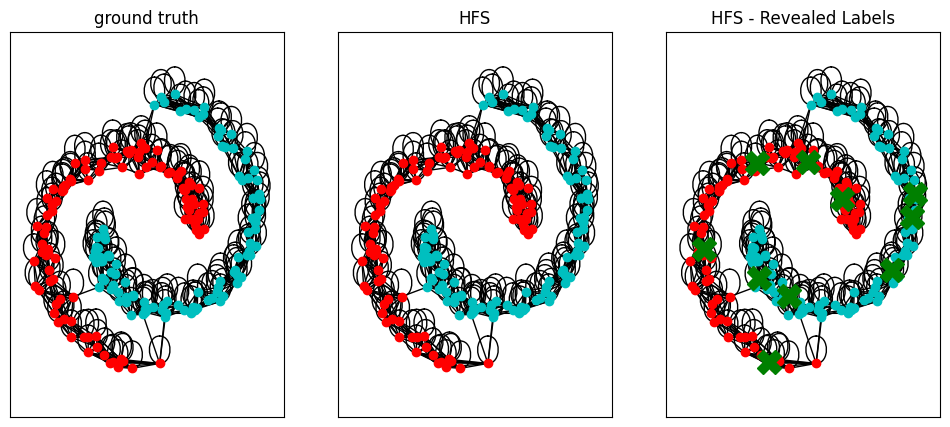

Soft=False, Accuracy=1.0


In [9]:
seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=seed, **params)

I opted to use the kNN approach to build the similarity graph with `k=10`, since this lead to good clustering results in the first TP. Overall, we can see that the model does an excellent job at predicting the unlabelled data with an accuracy of 100%. While this result is impressive, it could be interesting to see what impact the addition of noisy labels will bring to the model's performance.

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [10]:
np.random.seed(42)
for _ in range(20):
    try:
        X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, dataset='data_2moons_hfs_large.mat', plot=False, seed=None, **params)
    except AssertionError as e:
        print(f"Iteration failed: {e}")
        continue

print(help(mask_labels))

Iteration failed: only one class in training data!
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Iteration failed: only one class in training data!
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Help on function mask_labels in module helper:

mask_labels(Y, l, per_class=False)
    Function to select a subset of labels and mask the rest.

    Parameters
    ----------
    Y : array
        (n,) label vector, where entries Y_i take a value in [1, ..., C] , where C is the number of classes

    l : int
        Number of unmasked (revealed) labels to include in the output.

    per_class: bool, default: False
        If true, reveal l labe

The problem that can arise when choosing l as low as 4 is that the labels are masked in a way that all 4 nodes share the same class. This will lead to nonsensical training from which the model will then predict that one class for each unlabelled node. Therefore, it can make sense to set the `mask_labels` parameter `per_class=True`, since this will guarantee that we have an equal number of labelled nodes from each class in our training sample.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

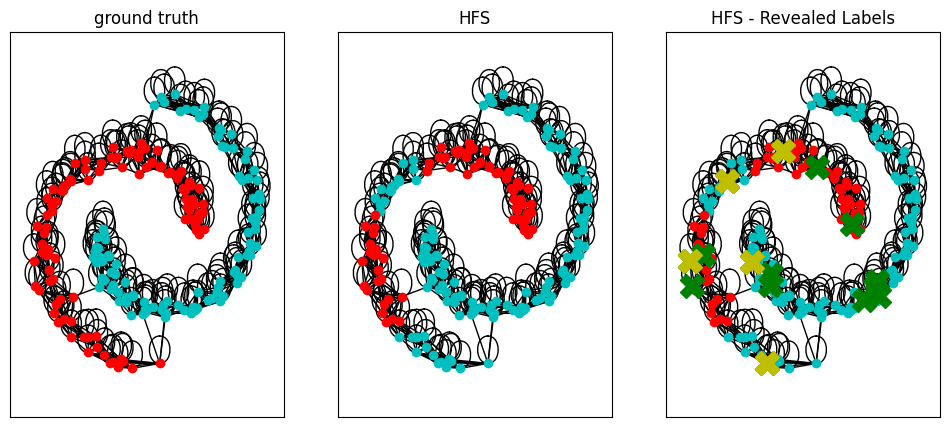

Soft=False, Accuracy=0.855


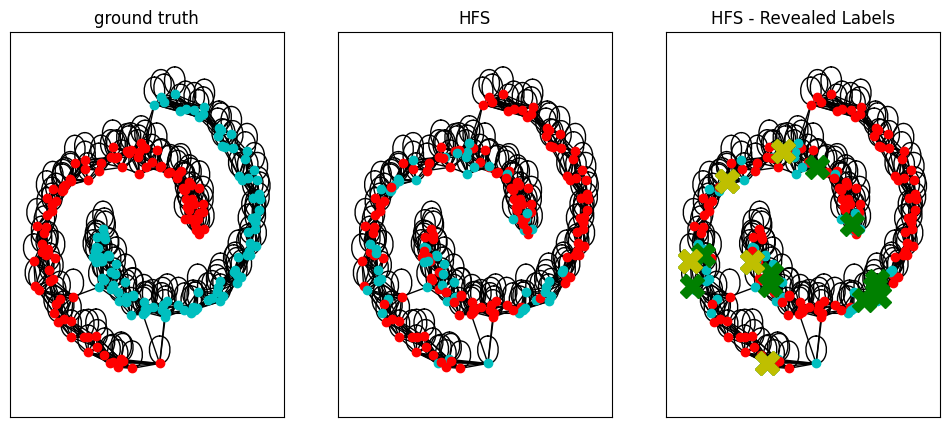

Soft=True, Accuracy=0.455


In [11]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset, plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset, plot=plot, seed=seed, **params)

When comparing hard and soft HFS in the two moon setting, we can observe that the hard classification achieves a better accuracy of 85.5% compared to the poor accuracy of 45.5% for the soft classification. Hard HFS' ability to largely preserve the original spiral pattern's class structure as seen in the ground truth leads to believe that it performs well on well-separated/structured data. Meanwhile, soft HFS' poor performance might be due to allowing too much flexibility in class assignments, which causes it to blur the originally clear boundaries between the spirals.

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

My implementation of the `compute_hfs` function handles multiple classes through a matrix-based approach where each class is represented as a column in a one-hot encoded matrix (as initially suggested in the comments of the code). Instead of working with binary labels, I create a matrix y of shape (num_samples, num_classes) where each row represents a sample and each column represents a class. The system is then solved simultaneously for all classes, producing predictions f with the same dimensionality, before finally applying the argmax operation along each row of f. This determines which class has the highest score for each sample, which is the exact extension that is needed to handle any number of classes (not just limited to 2).

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from load_images import load_image_data, plot_image_data, load_image_data_augmented, plot_image_data_augmented

from itertools import product
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [5]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 1.0
params_face_rec['var'] = 10000.0
params_face_rec['eps'] = None
params_face_rec['k'] = None
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 1.0
params_face_rec['c_u'] = 0.0

In [6]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

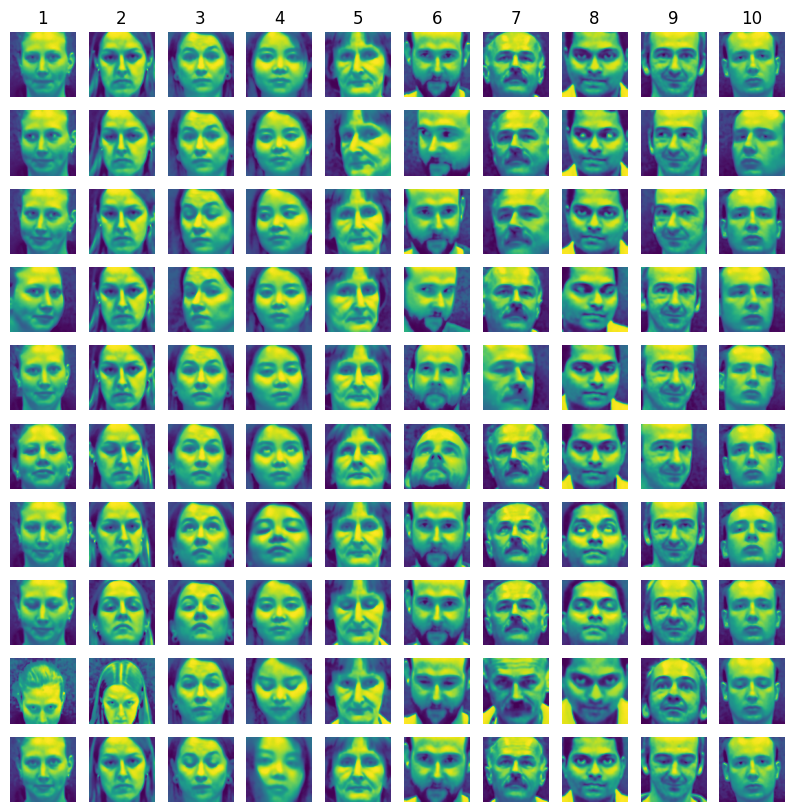

(100, 9216)
[[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.]
 [ 1.  2.  0.  4.  0.  0.  7.  0.  0.  0.]
 [ 1.  0.  3.  0.  0.  0.  0.  0.  9.  0.]
 [ 1.  0.  3.  0.  0.  6.  0.  0.  9. 10.]
 [ 0.  0.  0.  4.  5.  6.  0.  8.  0.  0.]
 [ 0.  0.  0.  4.  5.  0.  0.  0.  0.  0.]
 [ 0.  2.  3.  0.  0.  0.  0.  0.  9. 10.]
 [ 0.  0.  0.  0.  5.  6.  7.  0.  0. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  8.  9. 10.]
 [ 0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]]


In [15]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

plot_image_data(images)
print(images.shape)
print(masked_labels.reshape(-1, 10))

In [16]:
def grid_search(images, labels, masked_labels, param_ranges):

    best_accuracy = 0
    best_params = None
    best_predicted = None
    
    param_names = list(param_ranges.keys())
    param_values = list(param_ranges.values())
    combinations = list(product(*param_values))
    
    pbar = tqdm(total=len(combinations), desc="Testing parameters")
    
    for combo in combinations:
        current_params = dict(zip(param_names, combo))
        
        L = build_laplacian_regularized(images,
                                        current_params['laplacian_regularization'],
                                        current_params['var'],
                                        current_params['eps'],
                                        current_params['k'],
                                        current_params['laplacian_normalization'])
        
        predicted_labels, f = compute_hfs(L, masked_labels, soft=True, c_l=current_params['c_l'], c_u=current_params['c_u'])
        
        accuracy = np.equal(predicted_labels, labels).mean()
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = current_params.copy()
            best_predicted = predicted_labels.copy()
        
        pbar.update(1)
    
    pbar.close()
    return best_params, best_accuracy, best_predicted

Testing parameters: 100%|██████████| 12288/12288 [04:10<00:00, 49.06it/s]


Best parameters : {'laplacian_regularization': 0.0, 'var': 100.0, 'eps': 0.0, 'k': 5, 'laplacian_normalization': 'unn', 'c_l': 10.0, 'c_u': 0.1}
Accuracy =  0.85
[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.  1.  2.  0.  4.  0.  0.  7.  0.
  0.  0.  1.  0.  3.  0.  0.  0.  0.  0.  9.  0.  1.  0.  3.  0.  0.  6.
  0.  0.  9. 10.  0.  0.  0.  4.  5.  6.  0.  8.  0.  0.  0.  0.  0.  4.
  5.  0.  0.  0.  0.  0.  0.  2.  3.  0.  0.  0.  0.  0.  9. 10.  0.  0.
  0.  0.  5.  6.  7.  0.  0. 10.  0.  0.  0.  0.  5.  0.  0.  8.  9. 10.
  0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  3  9  7  8  9  9  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6 10  8
  1 10 10  2  4  4  5  4  7  8  1 10  1  2  3  4  5  6  7  3  9 10  1  2
 10  4  5  6  7 10  9 10  4  4  3  4  5  6  8  8  9 10  1  2  3  4  5  6
  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1 

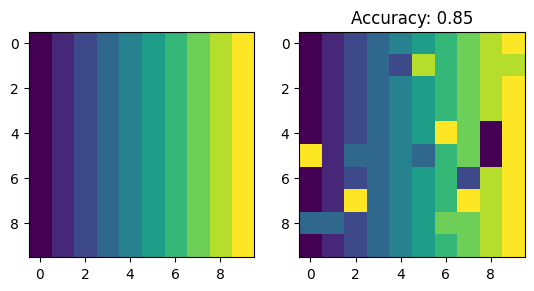

In [17]:
param_ranges = {'laplacian_regularization': [0.0, 0.1, 1.0, 10.0],
                'var': [1.0, 10.0, 100.0, 1000.0],
                'eps': [0.0, 1e-3, 1e-2, 1e-1],
                'k': [0, 5, 10, 15],
                'laplacian_normalization': ['unn', 'sym', 'rw'],
                'c_l': [0.1, 1.0, 10.0, 100.0],
                'c_u': [0.001, 0.01, 0.1, 1.0]}

best_params, best_accuracy, best_predicted = grid_search(images, labels, masked_labels, param_ranges)
print("Best parameters :", best_params)
print("Accuracy = ", best_accuracy)

print(masked_labels)
print(best_predicted)
print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(best_predicted.reshape((-1, 10)))
plt.title("Accuracy: {}".format(best_accuracy))
plt.show()

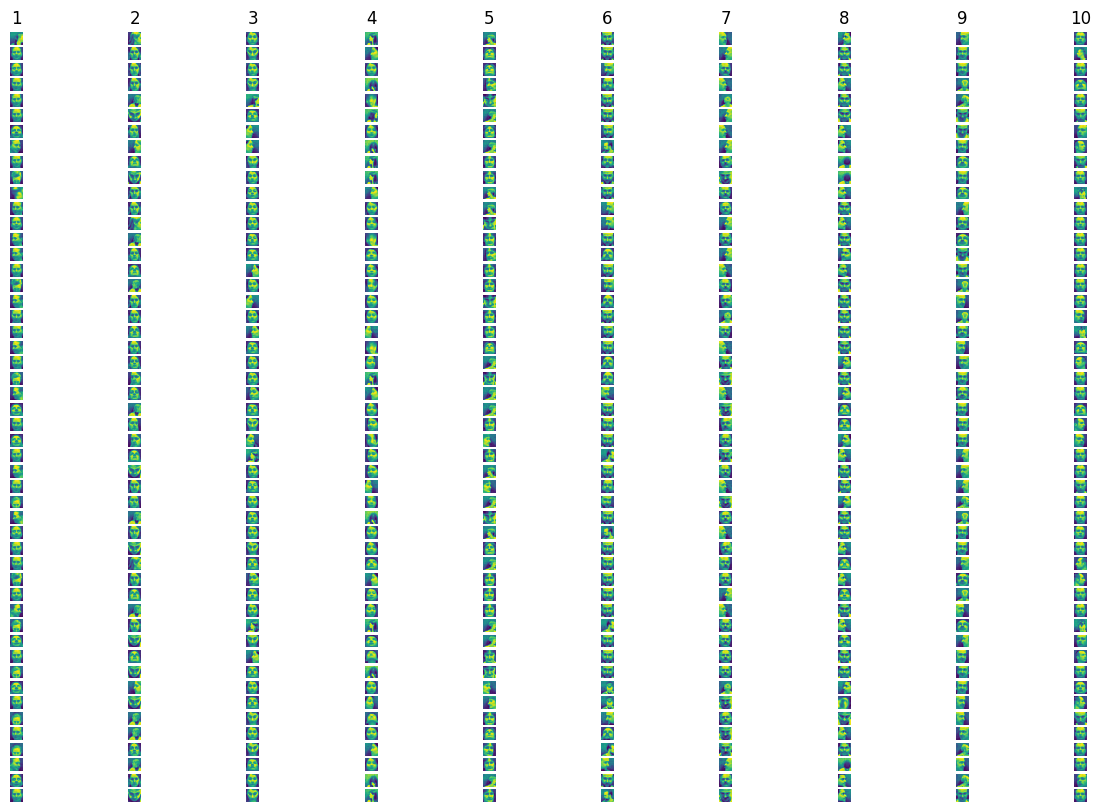

In [18]:
# 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

Accuracy =  0.626
[ 0.  0.  0.  0.  0.  6.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.
  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  7.  8.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.
  0.  0.  1.  2.  3.  0.  0.  0.  0.  0.  9.  0.  0.  2.  0.  0.  5.  6.
  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.
  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.
  0.  0.  0.  2.  0.  0.  5.  6.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. 

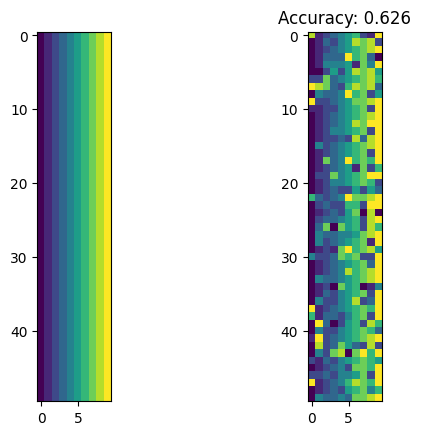

In [19]:
L_a = build_laplacian_regularized(images_a, best_params['laplacian_regularization'], best_params['var'], best_params['eps'], best_params['k'], best_params['laplacian_normalization'])

predicted_labels_a, f_a = compute_hfs(L_a, masked_labels_a, soft=True, c_l=best_params['c_l'], c_u=best_params['c_u'])
accuracy_a = np.equal(predicted_labels_a, labels_a).mean()
print("Accuracy = ", accuracy_a)

print(masked_labels_a)
print(predicted_labels_a)
print(labels_a)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy_a))
plt.show()

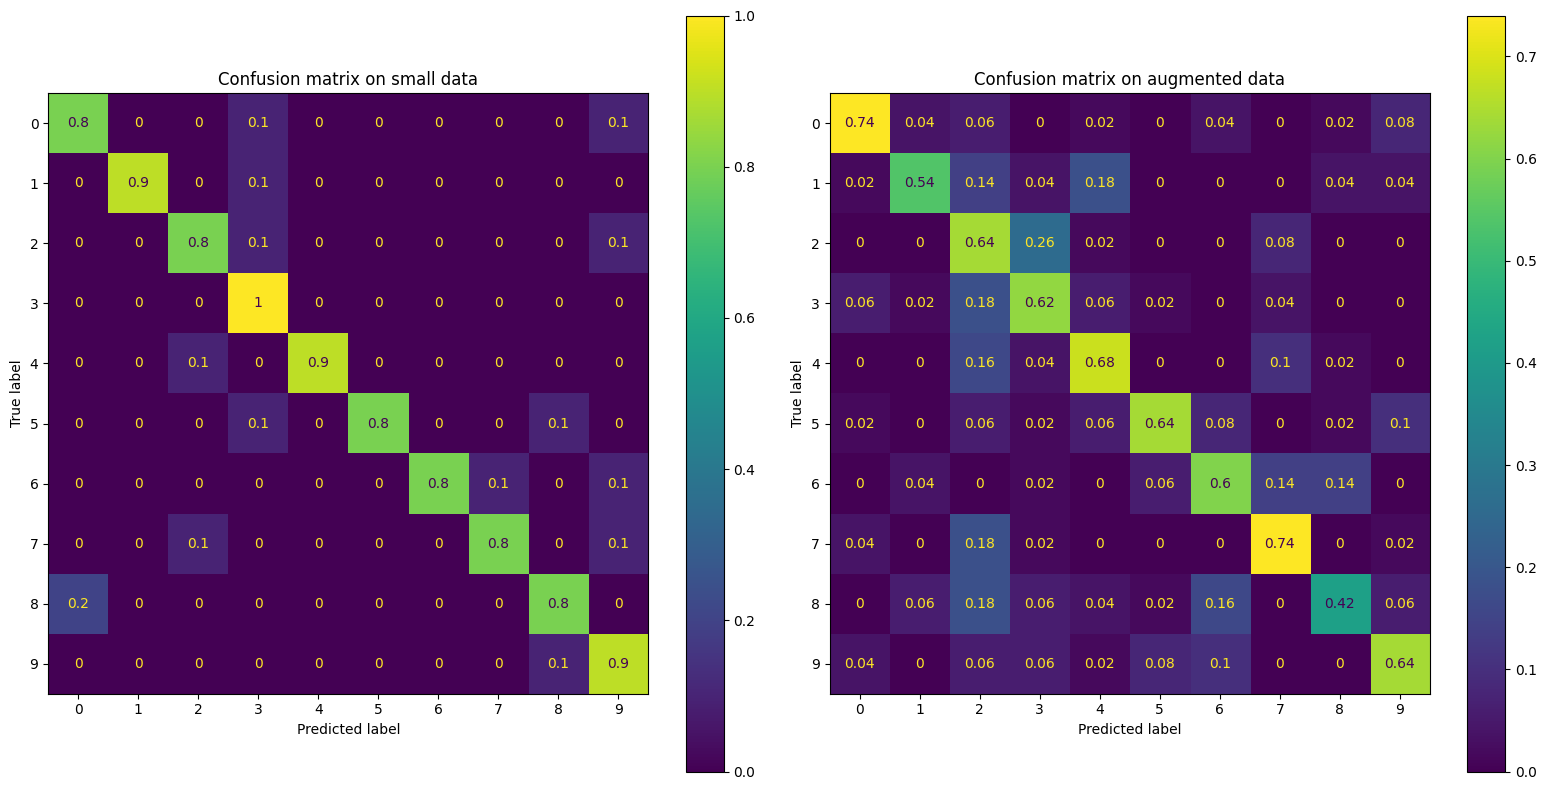

In [20]:
cm = confusion_matrix(labels, best_predicted)
cm = cm / cm.sum(axis=-1)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

cm_a = confusion_matrix(labels_a, predicted_labels_a)
cm_a = cm_a / cm_a.sum(axis=-1)
cm_display_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=np.arange(10))

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
cm_display.plot(ax=axs[0])
axs[0].set_title("Confusion matrix on small data")

cm_display_a.plot(ax=axs[1])
axs[1].set_title("Confusion matrix on augmented data")

plt.tight_layout()

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

Based on the obtained results, we can see that there was a drop in accuracy from 85% to 62.6% when moving from the standard dataset to the augmented dataset, while keeping the exact same parameters. This decrease suggests that the additional augmented data is actually counterproductive and is harming the model's performance. When taking a look at the plots showing the actual vs. predicted labels, we can see that for the original dataset we obtain fairly smooth layers (without many misclassifications), while the augmented dataset's predictions are much noisier and less structured. This indicates that the augmentation process may be introducing too much variation or noise that disrupts the natural differences of patterns and structures that we see in the original data.

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

In [7]:
import numpy as np
from scipy.spatial import distance

from helper_online_ssl import create_user_profile, online_face_recognition

In [8]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 0.05
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = 15
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = 0.8
params_online_ssl['c_u'] = 0.2

In [9]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            
            dist_copy = self.centroids_distances.copy()
            
            for i in range(dist_copy.shape[0]):
                for j in range(dist_copy.shape[1]):
                    if self.taboo[i] and self.taboo[j]:
                        dist_copy[i, j] = np.inf
            
            min_val = np.min(dist_copy)
            min_indices = np.where(dist_copy == min_val)
            c_1, c_2 = min_indices[0][0], min_indices[1][0]
            
            if self.taboo[c_1] and not self.taboo[c_2]:
                c_rep, c_add = c_1, c_2
            elif self.taboo[c_2] and not self.taboo[c_1]:
                c_rep, c_add = c_2, c_1
            else:
                if self.V[c_1] >= self.V[c_2]:
                    c_rep, c_add = c_1, c_2
                else:
                    c_rep, c_add = c_2, c_1
            
            self.V[c_rep] += self.V[c_add]
            
            self.centroids[c_add] = face
            
            self.V[c_add] = 1
            
            self.Y[c_add] = 0

            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])
            self.last_face = current_len

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        W = build_similarity_graph(self.centroids, var=params_online_ssl['var'], eps=params_online_ssl['eps'], k=params_online_ssl['k'])
        W = V @ W @ V
        L = build_laplacian(W, laplacian_normalization=params_online_ssl['laplacian_normalization'])
        Q = L + params_online_ssl['laplacian_regularization'] * np.eye(L.shape[0])  # regularized Laplacian

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, c_l=params_online_ssl['c_l'], c_u=params_online_ssl['c_u'])

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        threshold = 0.8
        for i in range(num_classes):
            label = self.label_names[i]
            score = f[self.last_face, i]
            if score >= threshold:
                label_scores.append((label, score))

        if not label_scores:
            return [('unknown', 1)]
        
        label_scores.sort(key=lambda x: x[1], reverse=True)

        return label_scores

In [24]:
# create_user_profile('oliver')

In [25]:
# create_user_profile('javier')

In [26]:
# online_face_recognition(['oliver', 'javier'], IncrementalKCenters, n_pictures=15)

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

For the training of the model, I used 15 images of both me (Oliver) and Javier captured at random with the `create_user_profile` function. After fine-tuning the parameters for quite a bit, I finally got satisfying results with the following parameters:
- `laplacian_regularization` = 0.05
- `k` = 15
- `laplacian_normalization` = unn
- `c_l` = 0.8
- `c_u` = 0.2

In the images down below, one can see that the algorithm is able to correctly classify both our faces, either separately or in a combined way, in particular with a very high accuracy (over 95%).

One thing I did however notice, is that the results were sometimes unstable when running the algorithm over a longer period of time, which is most likely due to the limited amount of training data (here it is only 15 images per known person).

![Example of Oliver](results/oliver.png)

![Example of Javier](results/javier.png)

![Example of two known people](results/oliver_javier.png)

### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.

Based on the original implementation of my algorithm, one can notice that a new person appearing in the image can be classified as one of the labels (Oliver or Javier), however, typically results in a lower accuracy score. Therefore, a natural way to classify people/objects as unknown would be to adopt a threshold method (here I used a threshold of 0.8), such that an accuracy score below that threshold leads to an "unknown" classification label.

As can be seen in the image down below where I held up a picture of the singer Dua Lipa, the model now manages to correctly classify unknown people as "unknown". (Note that the score no longer has a significant meaning for the "unknown" person and is simply kept as the score which lead to the unknown classification.)

![Example of one know person and one unknown person](results/oliver_dua.png)

### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification

The key to generating an automatic label for an unknown person who appears frequently would be to save all the unknown faces detected as well as their indices in lists. Once this temporary buffer reaches full capacity (chosen by the user or depending on the hardware constarints), the algorithm should analyze whether the most recently detected "unknown" face has appeared sufficiently often. This can be determined by checking if the number of other faces with a close distance exceeds a certain threshold (once again determined by the user, could be for example the number of pictures used for the different known faces during training). If this happens to be the case, we can then create a new label (e.g. AutoBob) and add it to our label list. Finally, the associated faces are subsequently removed from the unknown faces buffer. When this face appears again, the algorithm will display the newly assigned classification.

### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time.
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once.

## Approach

My experiments use the previously used image data obtained from the function `load_image_data`. For the different experiments, I compared different learning approaches: supervised vs. semi-supervised (using graph-based HFS vs. SVM), inductive vs. transductive (evaluating on seen vs. unseen data), and online vs. batch learning (incremental updates vs. all-at-once training).

## Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from helper import build_similarity_graph, build_laplacian
from load_images import load_image_data

## Prepare data

In [11]:
images, true_labels, masked_labels = load_image_data()

label_names = [f"Person_{i}" for i in range(1, max(true_labels) + 1)]

X_train, X_test, y_train, y_test, masked_train, masked_test = train_test_split(images, true_labels, masked_labels, test_size=0.2, random_state=42)

labeled_indices = np.where(masked_train != 0)[0]
unlabeled_indices = np.where(masked_train == 0)[0]

X_labeled = X_train[labeled_indices]
y_labeled = masked_train[labeled_indices]

params_ssl = {'var': 0.5,
              'eps': 0.1,
              'k': 5,
              'laplacian_normalization': 'sym',
              'laplacian_regularization': 0.01,
              'c_l': 1.0,
              'c_u': 0.1}

initial_faces = []
initial_labels = []

for label in range(1, max(true_labels) + 1):
    class_indices = np.where(masked_train[labeled_indices] == label)[0]
    if len(class_indices) > 0:
        initial_faces.append(X_train[labeled_indices[class_indices[0]]])
        initial_labels.append(label)

initial_faces = np.array(initial_faces)
initial_labels = np.array(initial_labels)

## Supervised vs. Semi-supervised

Supervised learning accuracy: 0.6125
Semi-supervised learning accuracy: 0.5250


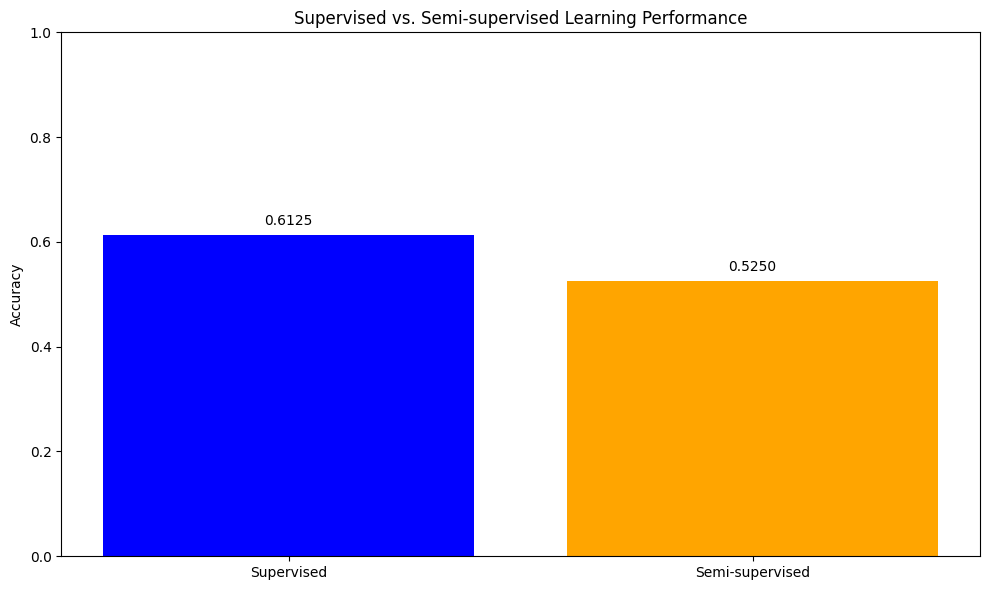

In [13]:
supervised_model = SVC(kernel='rbf', gamma='scale')
supervised_model.fit(X_labeled, y_labeled)
supervised_pred = supervised_model.predict(X_train)
supervised_accuracy = accuracy_score(y_train, supervised_pred)

W = build_similarity_graph(X_train, var=params_ssl['var'], eps=params_ssl['eps'], k=params_ssl['k'])

L = build_laplacian(W, laplacian_normalization=params_ssl['laplacian_normalization'])

Q = L + params_ssl['laplacian_regularization'] * np.eye(L.shape[0])

ssl_labels, _ = compute_hfs(Q, masked_train, soft=False, c_l=params_ssl['c_l'], c_u=params_ssl['c_u'])

ssl_accuracy = accuracy_score(y_train, ssl_labels)

print(f"Supervised learning accuracy: {supervised_accuracy:.4f}")
print(f"Semi-supervised learning accuracy: {ssl_accuracy:.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
methods = ['Supervised', 'Semi-supervised']
accuracies = [supervised_accuracy, ssl_accuracy]
ax.bar(methods, accuracies, color=['blue', 'orange'])
ax.set_ylim([0, 1])
ax.set_ylabel('Accuracy')
ax.set_title('Supervised vs. Semi-supervised Learning Performance')
for i, v in enumerate(accuracies):
    ax.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

The results show that supervised learning outperforms semi-supervised learning in terms of accuracy. One reason for this could be that the graph-based semi-supervised method created misleading connections between face samples from different classes or because the unlabeled data introduced noise rather than helpful structure.

## Inductive vs. Transductive

Supervised Learning:
Transductive Accuracy: 0.6125
Inductive Accuracy: 0.4000
Semi-supervised Learning:
Transductive Accuracy: 0.4625
Inductive Accuracy: 0.3000


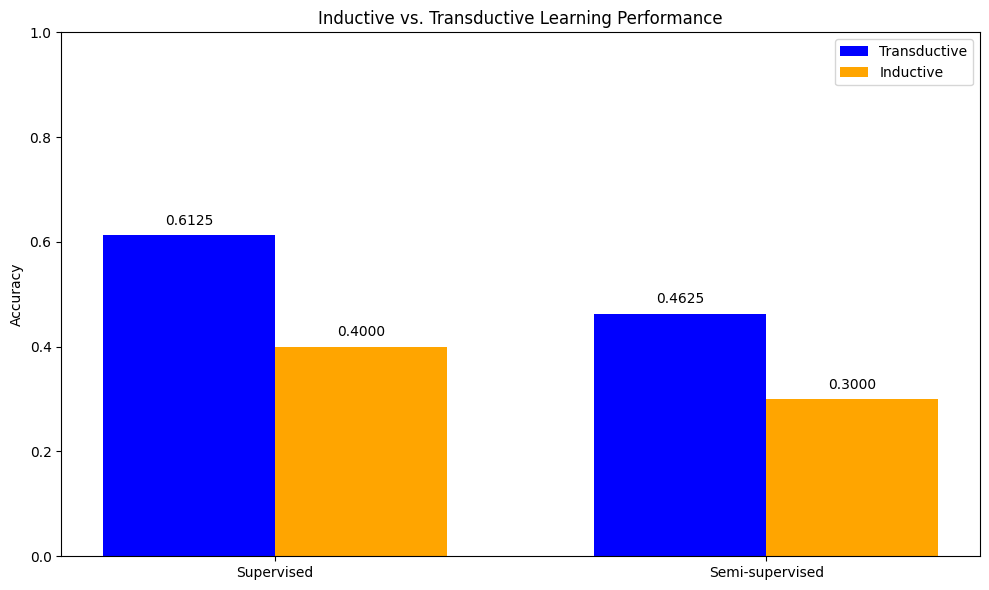

In [14]:
supervised_model = SVC(kernel='rbf', gamma='scale')
supervised_model.fit(X_labeled, y_labeled)

supervised_transductive_pred = supervised_model.predict(X_train)
supervised_transductive_acc = accuracy_score(y_train, supervised_transductive_pred)

supervised_inductive_pred = supervised_model.predict(X_test)
supervised_inductive_acc = accuracy_score(y_test, supervised_inductive_pred)

W_train = build_similarity_graph(X_train, var=params_ssl['var'], eps=params_ssl['eps'], k=params_ssl['k'])

L_train = build_laplacian(W_train, laplacian_normalization=params_ssl['laplacian_normalization'])

Q_train = L_train + params_ssl['laplacian_regularization'] * np.eye(L_train.shape[0])

ssl_transductive_labels, f_train = compute_hfs(Q_train, masked_train, soft=True, c_l=params_ssl['c_l'], c_u=params_ssl['c_u'])

ssl_transductive_acc = accuracy_score(y_train, ssl_transductive_labels)

X_train_with_ssl_labels = X_train
y_train_with_ssl_labels = ssl_transductive_labels

ssl_inductive_model = SVC(kernel='rbf', gamma='scale')
ssl_inductive_model.fit(X_train_with_ssl_labels, y_train_with_ssl_labels)
ssl_inductive_pred = ssl_inductive_model.predict(X_test)
ssl_inductive_acc = accuracy_score(y_test, ssl_inductive_pred)

print("Supervised Learning:")
print(f"Transductive Accuracy: {supervised_transductive_acc:.4f}")
print(f"Inductive Accuracy: {supervised_inductive_acc:.4f}")
print("Semi-supervised Learning:")
print(f"Transductive Accuracy: {ssl_transductive_acc:.4f}")
print(f"Inductive Accuracy: {ssl_inductive_acc:.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
methods = ['Supervised', 'Semi-supervised']
transductive_accs = [supervised_transductive_acc, ssl_transductive_acc]
inductive_accs = [supervised_inductive_acc, ssl_inductive_acc]

x = np.arange(len(methods))
width = 0.35

ax.bar(x - width/2, transductive_accs, width, label='Transductive', color='blue')
ax.bar(x + width/2, inductive_accs, width, label='Inductive', color='orange')

ax.set_ylim([0, 1])
ax.set_ylabel('Accuracy')
ax.set_title('Inductive vs. Transductive Learning Performance')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

for i, v in enumerate(transductive_accs):
    ax.text(i - width/2, v + 0.02, f'{v:.4f}', ha='center')
for i, v in enumerate(inductive_accs):
    ax.text(i + width/2, v + 0.02, f'{v:.4f}', ha='center')
    
plt.tight_layout()
plt.show()

The results show that transductive learning consistently outperforms inductive learning across both supervised and semi-supervised approaches. Nevertheless, the gap between transductive and inductive performance is smaller for semi-supervised learning.

## Online vs. Batch

Online learning (all data) final accuracy: 0.8500
Batch learning (all data) final accuracy: 0.8500
Batch learning (labelled subset only) final accuracy: 0.6125


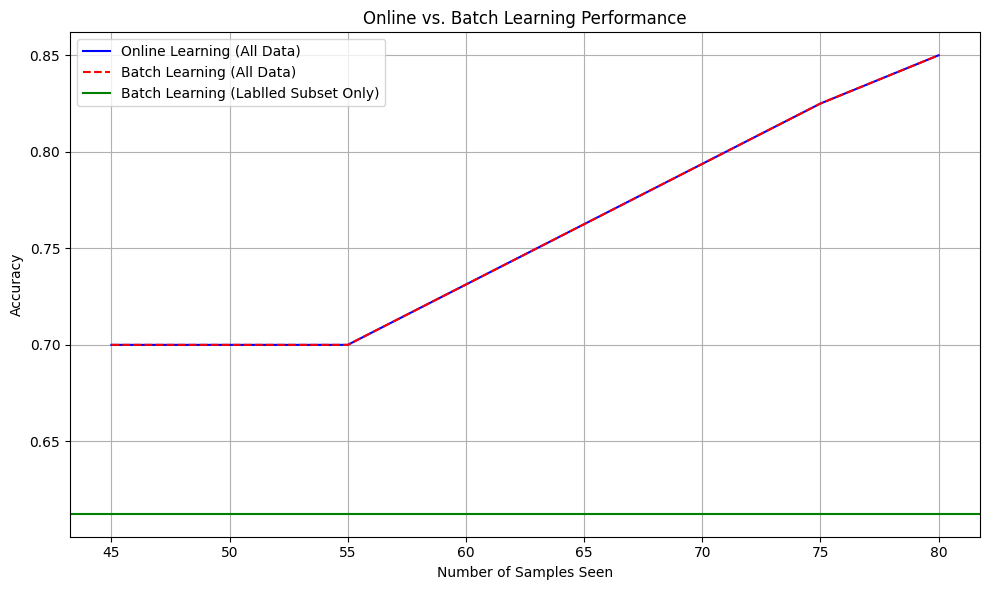

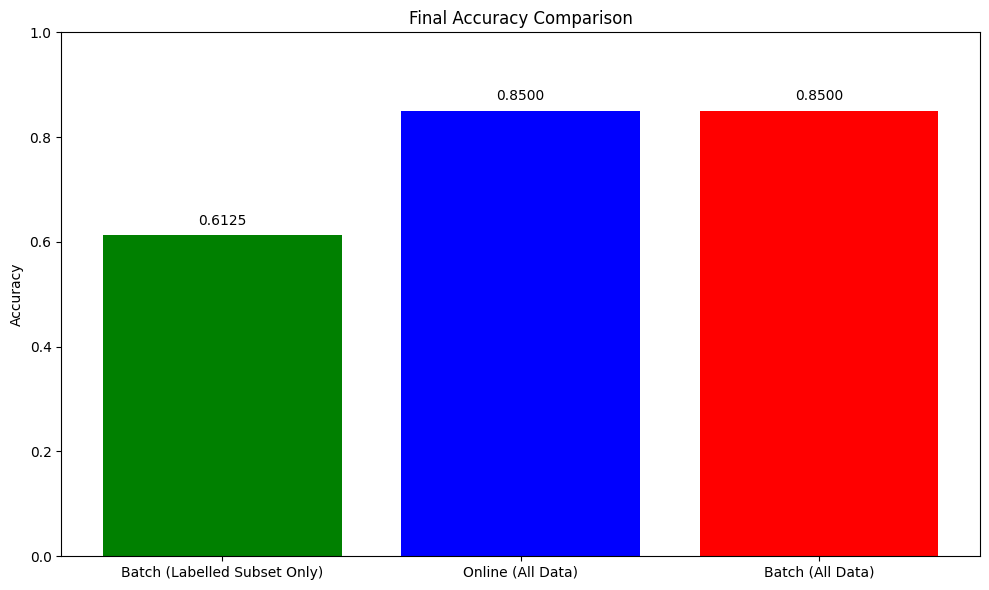

In [15]:
batch_model = SVC(kernel='rbf', gamma='scale')
batch_model.fit(X_labeled, y_labeled)
batch_pred = batch_model.predict(X_train)
batch_accuracy = accuracy_score(y_train, batch_pred)

X_online = X_labeled.copy()
y_online = y_labeled.copy()

online_accuracies = []
batch_accuracies = []
sample_counts = []

remaining_indices = np.setdiff1d(np.arange(len(X_train)), labeled_indices)
np.random.shuffle(remaining_indices)

batch_size = max(10, len(remaining_indices) // 10)
for i in range(0, len(remaining_indices), batch_size):
    batch_indices = remaining_indices[i:i+batch_size]
    
    X_batch = X_train[batch_indices]
    y_batch = y_train[batch_indices]
    
    X_online = np.vstack([X_online, X_batch])
    y_online = np.append(y_online, y_batch)
    
    online_model = SVC(kernel='rbf', gamma='scale')
    online_model.fit(X_online, y_online)
    online_pred = online_model.predict(X_train)
    online_acc = accuracy_score(y_train, online_pred)
    
    online_accuracies.append(online_acc)
    
    seen_indices = np.concatenate([labeled_indices, remaining_indices[:i+batch_size]])
    X_seen = X_train[seen_indices]
    y_seen = y_train[seen_indices]
    
    batch_model_partial = SVC(kernel='rbf', gamma='scale')
    batch_model_partial.fit(X_seen, y_seen)
    batch_pred_partial = batch_model_partial.predict(X_train)
    batch_acc_partial = accuracy_score(y_train, batch_pred_partial)
    
    batch_accuracies.append(batch_acc_partial)
    sample_counts.append(len(X_online))

print(f"Online learning (all data) final accuracy: {online_accuracies[-1]:.4f}")
print(f"Batch learning (all data) final accuracy: {batch_accuracies[-1]:.4f}")
print(f"Batch learning (labelled subset only) final accuracy: {batch_accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(sample_counts, online_accuracies, 'b-', label='Online Learning (All Data)')
plt.plot(sample_counts, batch_accuracies, 'r--', label='Batch Learning (All Data)')
plt.axhline(y=batch_accuracy, color='g', linestyle='-', label='Batch Learning (Lablled Subset Only)')
plt.xlabel('Number of Samples Seen')
plt.ylabel('Accuracy')
plt.title('Online vs. Batch Learning Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
methods = ['Batch (Labelled Subset Only)', 'Online (All Data)', 'Batch (All Data)']
final_accuracies = [batch_accuracy, online_accuracies[-1], batch_accuracies[-1]]
plt.bar(methods, final_accuracies, color=['green', 'blue', 'red'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Final Accuracy Comparison')
for i, v in enumerate(final_accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

The results show the impact of the quantity of data when it comes to the different approaches. The learning curve shown in the first plot illustrate that both online and batch learning show a general improvement as the number of samples seen grows. On the other hand, batch learning shows a weaker overall performance, due to the fact it doesn't leverage additional data.